# Computational Notebook for Baseline Model

The goal of this notebook is to implement and play with the baseline vanilla model.

First, let's load some dependencies.

In [1]:
# Dependencies
using Pkg 
pkg"activate .."
pkg"instantiate" # will download the right packages if you don't have them 
pkg"precompile" # will precompile them for easy use
using LinearAlgebra, Statistics
using Distributions, Plots, StatsPlots, Expectations, Parameters

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


Next, let's define the baseline model.

In [2]:
Model = @with_kw (λ_bar = 1/2, # market threshold for investing
                    λ = 1/3, # common prior about share of high types
                    R = 1/2, # payoff from investment
                    ω_L = Uniform(0, 1), # low type outside option distribution
                    ω_H = Uniform(0, 1), # high type outside option distribution
                    F_L = x -> cdf(ω_L, x), # these are based on the previous distributions
                    F_H = x -> cdf(ω_H, x),
                    f_L = x -> pdf(ω_L, x),
                    f_H = x -> pdf(ω_H, x))

#3 (generic function with 2 methods)

We can create an object using the parameters set above.

In [3]:
baseline = Model();
@show baseline.λ, baseline.ω_L;

(baseline.λ, baseline.ω_L) = (0.3333333333333333, Uniform{Float64}(a=0.0, b=1.0))


We can also tweak the parameters a bit.

In [4]:
high_λ = Model(λ = 0.99);
@show high_λ.λ, high_λ.ω_L;

(high_λ.λ, high_λ.ω_L) = (0.99, Uniform{Float64}(a=0.0, b=1.0))


Everything we don't explicitly set uses the default values.

Now, let's write an equilibrium utility routine (assuming an interior solution).

In [5]:
function utility(vals; m = baseline)
    ϕ, p = vals
    @unpack λ_bar, λ, R, ω_L, ω_H, F_L, F_H, f_L, f_H = m 
    # test for constraint satisfaction, return 0 otherwise 
    if ϕ*F_L(ϕ*R - p)*λ_bar*(1-λ) > F_H(R - p)*λ*(1-λ_bar) # if this constraint is violated, no investment occurs. 
        return 0. 
    end
    # return the actual utility
    return 100*p*(λ*F_H(R - p) + (1-λ)*F_L(ϕ*R - p)) # multiply by 100 for legibility
end

utility (generic function with 1 method)

Note that the above is a complete statement of the problem, independent of any FOCs, etc. Maximizing the function above, subject to nonnegativity constraints, will give you an interior solution.

We can try giving it to a nonlinear solver.

## Nonlinear Solver

In [6]:
using BlackBoxOptim, Suppressor

Let's do the baseline model first.

We run a global solver for 20 seconds in each case, which seemed to be enough.

In [7]:
m = baseline
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20); # run a global solver for 20 seconds

In [8]:
println("utility = $(-best_fitness(res))")
println("ϕ = $(best_candidate(res)[1])")
println("p = $(best_candidate(res)[2])")
println("e_L = $(m.F_L(best_candidate(res)[1]*m.R - best_candidate(res)[2]))")
println("e_H = $(m.F_H(m.R - best_candidate(res)[2]))")

utility = 4.668667279470503
ϕ = 0.802721288952871
p = 0.23843956967399385
e_L = 0.16292107480244164
e_H = 0.2615604303260062


We can try tweaking parameters.

##### λ = 0.75
---------

In [9]:
m = Model(λ = 0.75) # up from 1/3
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);

In [10]:
println("utility = $(-best_fitness(res))")
println("ϕ = $(best_candidate(res)[1])")
println("p = $(best_candidate(res)[2])")
println("e_L = $(m.F_L(best_candidate(res)[1]*m.R - best_candidate(res)[2]))")
println("e_H = $(m.F_H(m.R - best_candidate(res)[2]))")

utility = 6.250000000000001
ϕ = 1.0
p = 0.24999999988225677
e_L = 0.25000000011774326
e_H = 0.25000000011774326


##### $\lambda_{\text{bar}} = 0.75$
---------

In [11]:
m = Model(λ_bar = 0.75) # up from 1/2
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);

In [12]:
println("utility = $(-best_fitness(res))")
println("ϕ = $(best_candidate(res)[1])")
println("p = $(best_candidate(res)[2])")
println("e_L = $(m.F_L(best_candidate(res)[1]*m.R - best_candidate(res)[2]))")
println("e_H = $(m.F_H(m.R - best_candidate(res)[2]))")

utility = 3.2048932147634908
ϕ = 0.6067158553343035
p = 0.2288806202066558
e_L = 0.07447730746049594
e_H = 0.2711193797933442


##### R = 0.75
---------

In [13]:
m = Model(R = 0.75) # up from 1/2
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);

In [14]:
println("utility = $(-best_fitness(res))")
println("ϕ = $(best_candidate(res)[1])")
println("p = $(best_candidate(res)[2])")
println("e_L = $(m.F_L(best_candidate(res)[1]*m.R - best_candidate(res)[2]))")
println("e_H = $(m.F_H(m.R - best_candidate(res)[2]))")

utility = 10.504501378808632
ϕ = 0.8027212888580167
p = 0.3576593542457741
e_L = 0.24438161239773848
e_H = 0.3923406457542259


We can also try tweaking the distriibutions.

Here we alter the high type distribution.

In [15]:
m = Model(ω_H = Uniform(0.25, 1.25)) # from U(0, 1)
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);

In [16]:
println("utility = $(-best_fitness(res))")
println("ϕ = $(best_candidate(res)[1])")
println("p = $(best_candidate(res)[2])")
println("e_L = $(m.F_L(best_candidate(res)[1]*m.R - best_candidate(res)[2]))")
println("e_H = $(m.F_H(m.R - best_candidate(res)[2]))")

utility = 1.5625000000000004
ϕ = 0.5
p = 0.12500000066995345
e_L = 0.12499999933004655
e_H = 0.12499999933004657


Now let's alter the low type distribution.

In [17]:
m = Model(ω_L = Uniform(0.75, 1.75)) # from U(0, 1)
res = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 30);

In [18]:
println("utility = $(-best_fitness(res))")
println("ϕ = $(best_candidate(res)[1])")
println("p = $(best_candidate(res)[2])")
println("e_L = $(m.F_L(best_candidate(res)[1]*m.R - best_candidate(res)[2]))")
println("e_H = $(m.F_H(m.R - best_candidate(res)[2]))")

utility = 2.0833333333333335
ϕ = 0.5949378462176252
p = 0.2500000011446236
e_L = 0.0
e_H = 0.24999999885537638


## Plots

We can also plot utility over the entire parameter space.

For each one

In [19]:
using Plots, LaTeXStrings

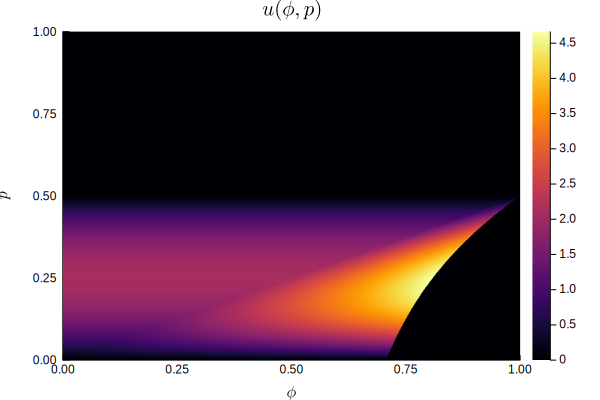

In [20]:
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p)")

And in the tweaked cases.

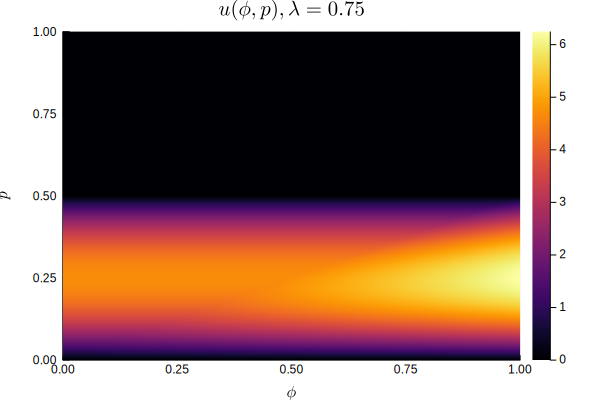

In [21]:
m = Model(λ = 0.75) # up from 0.5
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]; m = m), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p), \lambda = 0.75")

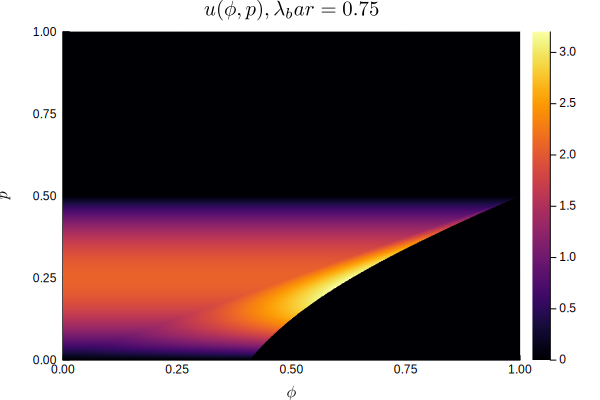

In [22]:
m = Model(λ_bar = 0.75) # up from 0.5
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]; m = m), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p), \lambda_bar = 0.75")

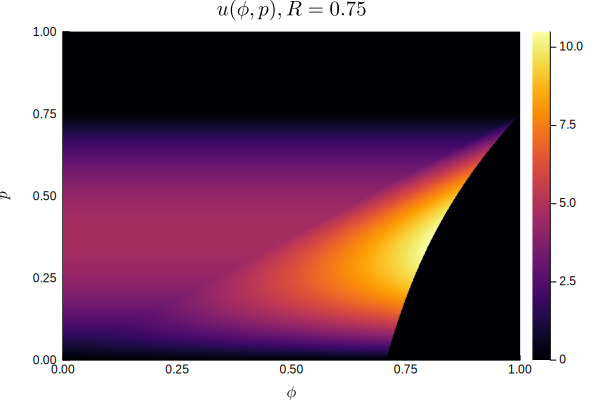

In [23]:
m = Model(R = 0.75) # up from 0.5
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]; m = m), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p), R = 0.75")

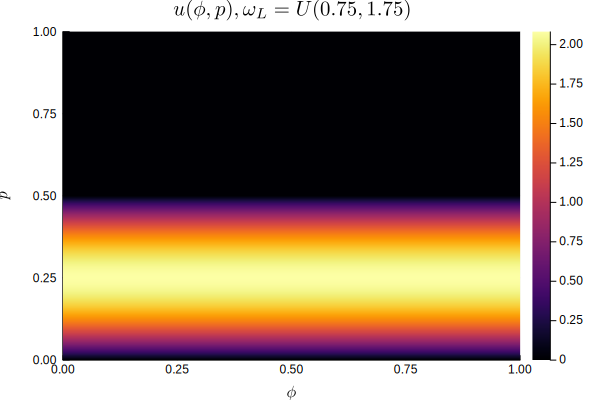

In [24]:
m = Model(ω_L = Uniform(0.75, 1.75)) # from U(0, 1)
heatmap(0.:0.00125:1.0, 0.:0.00125:1.0, (ϕ, p) -> utility([ϕ, p]; m = m), xlabel = L"\phi", ylabel = L"p", title = L"u(\phi, p), \omega_L = U(0.75, 1.75)")

This plot is interesting, it suggests that there's an infinity of optima? Maybe there aren't enough low types to muck things up.

## Continuously Varying the Distributions

For this experiment, we'll parametrize each distribution as a linear density on $[0, 1]$ given by: 


$$ f(z) = 1 + a(z - \frac{1}{2}) $$

for $a \in [-5, 5]$

First, let's write a new function to calculate utility at each $(a_H, a_L)$.

In [25]:
using QuadGK # numerical integration package

In [26]:
function utility_given_as(a_H, a_L) 
    # using a_H and a_L, create our new model 
    f_H = z -> z < 0 || z > 1 ? 0. : 1 + a_H*(z - 1/2)
    f_L = z -> z < 0 || z > 1 ? 0. : 1 + a_L*(z - 1/2)
    F_H = z -> quadgk(f_H, 0., z)[1]
    F_L = z -> quadgk(f_L, 0., z)[1]
    m = Model(f_H = f_H, f_L = f_L, F_H = F_H, F_L = F_L)
    # find the utility under this model 
    result = @suppress bboptimize(x -> -1*utility(x; m = m), SearchRange = (0.0, 1.0), NumDimensions = 2, MaxTime = 20);
    return -1 * best_fitness(result)
end

utility_given_as (generic function with 1 method)

Fixing $a_H = 0$, we can examine the impact of varying $a_L$ on utility. 

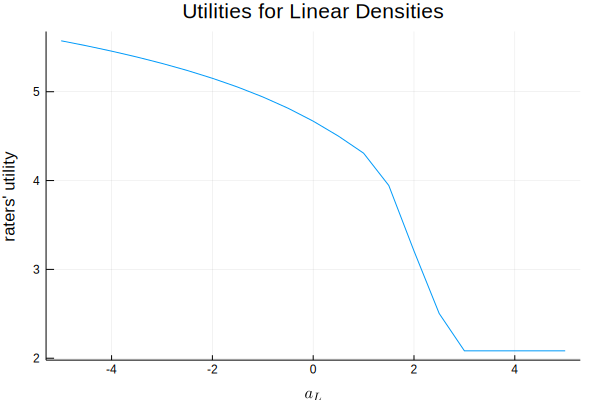

In [28]:
plot(x -> utility_given_as(0.0, x), -5:0.5:5., xlabel = L"a_L", ylabel = "raters' utility", title = "Utilities for Linear Densities", legend = false)